# Primer trabajo introducción a la minería de datos

1. Llene la columna tipo del diccionario de datos.
2. Cargue en python el dataset y analice las variables Atry to Lecture, TaskStrategies  y completer. Obtenga por cada una valores mínimos y máximo, medidas de tendencia central, entre otras. Concluya al respecto.
3. Construya un gráfico de cajas y bigotes para TaskStrategies, en relación con SI GANÓ O PERDIÓ.  Realice otro gráfico de cajas y bigotes para Atry to Lecture. Concluya al respecto.
4. Solucione los problemas referentes a calidad de datos presentes en el dataset. Describa los pasos realizados de manera ejecutiva.
5. Construya 10 gráficos a partir del dataset. Deben ser gráficos que permitan extraer conclusiones relevantes (algunas sugerencias se presentan en las siguientes imágenes). Deben elegir gráficos acordes al tipo de dato. Cada figura debe presentarse siguiendo normas APA.
6. Concluya sobre los hallazgos encontrados ¿Qué variables son relevantes para ganar el espacio académico? Puede sugerir algunas acciones para que la institución educativa mejore el rendimiento de sus estudiantes a partir de esas variables. [Jose]
7. Construya una historia con los datos [Jose y Sebas]


#PUNTO 1 

Llene la columna Tipo (Categórico o numérico) de la tabla anterior (poner entero, real, categórica ordinal o nominal)

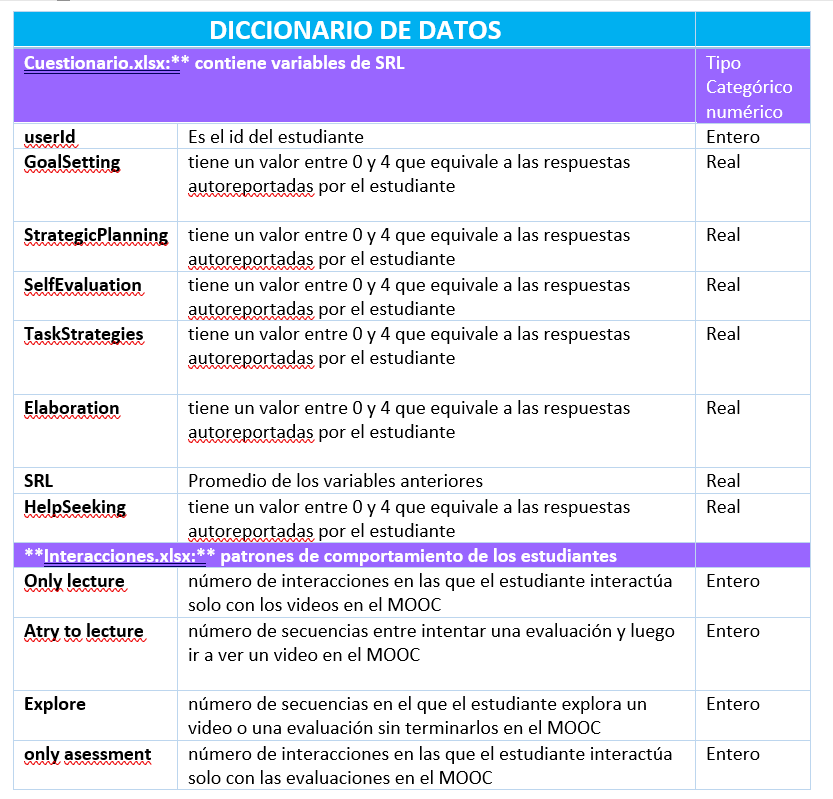

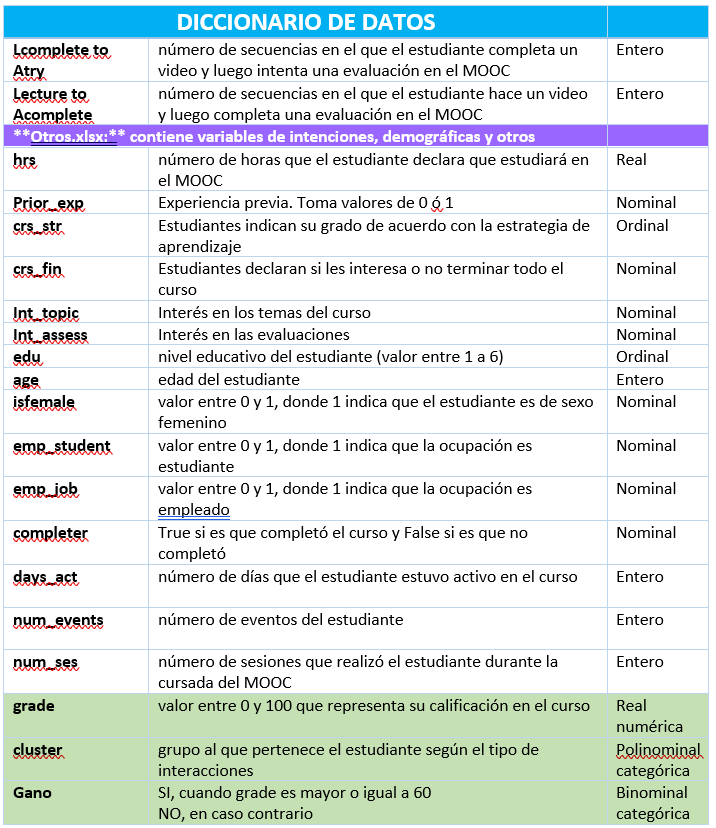



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 4.2 MB/s 


In [ ]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     \ 21.9 MB 177 kB/s
     |████████████████████████████████| 102 kB 4.3 MB/s 
     |████████████████████████████████| 4.7 MB 30.5 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 812 kB 46.1 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=261257 sha256=ada9e43e31968034b143fc52f8b113bf0a9ced7e4597147f64cb45bd9c7a763e
  Stored in directory: /tmp/pip-ephem-wheel-cache-2toa3zym/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=455be548e52fef69d5444e6eba557660d632ee47ead83452b0d0aa2079c7a1a7
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d250ba868768823940c3229e9950d201a26d0bd3ee8655
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=29520

In [ ]:
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np
from pathlib import Path
import phik
from plotly import express as px
import plotly.graph_objs as go
from google.colab  import drive
import sklearn
import textwrap

wraper = textwrap.TextWrapper(width=100,
    initial_indent=" " * 4,
    subsequent_indent=" " * 4,
    break_long_words=False,
    break_on_hyphens=False)

wprint = lambda string: print(wraper.fill(string))

Definición estilo de gráficos

In [ ]:
class Estilo:
  def __init__(self, colores=None):
    if colores is None:
      self.colores = {
          'femenino':'#ff69b4',
          'masculino':'#7858da',
          'correcto':'#1CDB59',
          'incorrecto':'#fa1e1e',
          'c1':'#79216d',
          'c2':'#ca1e3f',
          'c3':'#b26116',
          'c4':'#a0933a',
          'c5':'#a3f789'
      }
    else:
      self.colores = colores

    self.color_discrete_sequence=[self.colores[c] for c in ['c1','c2','c3','c4','c5']]
    self.color_continuous_scale = ["#fff", self.colores['c1']]

  def heatmap(self, df, **kwargs):
    return px.imshow(df, color_continuous_scale=self.color_continuous_scale,**kwargs)

  def box(self, df, x=None, y=None, title=None, notched=True, **kwargs):
    if title is None:
      title=f'Boxplot {x} vs {y}' if x is not None else f'Boxplot {y}'
    return px.box(df, x=x, y=y, title=title, notched=notched,
                  color_discrete_sequence=self.color_discrete_sequence, **kwargs)

  def histogram(self, df, x=None, text_auto=True,**kwargs):
    return px.histogram(df, x=x, text_auto=text_auto, 
                        color_discrete_sequence=self.color_discrete_sequence, **kwargs)

  def scatter(self, df, correct_incorrect_map=None,**kwargs):
    if correct_incorrect_map is None:
      return px.scatter(data_frame=df, 
                        color_discrete_sequence=self.color_discrete_sequence, **kwargs)
    else:
      color_discrete_map = {
          correct_incorrect_map['correcto']:self.colores['correcto'],
          correct_incorrect_map['incorrecto']:self.colores['incorrecto']
                            }
      return px.scatter(data_frame=df, color_discrete_map=color_discrete_map, **kwargs)

  def pyramid(self, df, x, bins, cat_col, cat1, cat1name, cat1color, cat2, cat2name, cat2color):
    min = df[x].min()
    max = df[x].max()
    limites = [round(x) for x in np.linspace(min, max, bins)]
    labels = [f'[{lim_min}-{lim_max})' 
              for (lim_min, lim_max) in zip(limites[0:bins-1],limites[1:bins])]

    bins_1 = pd.cut(df.loc[df[cat_col] == cat1][x], bins=limites, labels=labels, include_lowest=True)
    bins_2 = pd.cut(df.loc[df[cat_col] == cat2][x], bins=limites, labels=labels, include_lowest=True)

    bins_1.name = cat1name
    bins_2.name = cat2name

    grouped_1 = bins_1.groupby(bins_1).count()
    grouped_2 = bins_2.groupby(bins_2).count()

    data = pd.DataFrame([grouped_1, grouped_2]).transpose()

    y = data.index
    x_1 = data[cat1name]
    x_2 = data[cat2name] * (-1)
    meta = data[cat2name]

    fig = go.Figure()
    bar1 = go.Bar(y=y, x=x_1, name=cat1name, orientation = 'h', 
                  texttemplate='%{x}',marker_color=cat1color)
    bar2 = go.Bar(y=y, x=x_2, name=cat2name, orientation = 'h', 
                  texttemplate='%{meta}',marker_color=cat2color,meta=meta)
    fig.add_trace(bar1)
    fig.add_trace(bar2)
    fig.update_layout(title='Pirámide poblacional', barmode='relative',bargap=0.0, 
                      bargroupgap = 0 )
    return fig

In [ ]:
estilo = Estilo()

In [ ]:
parent_jose = r'/content/drive/MyDrive/Uniquindío/Maestría en Ingeniería/Cohorte II'
parent_sebas = r''

parent = parent_jose
archivo_inicial = r'/Dataset_final.xlsx'
archivo_limpio = r'/Dataset_final_limpio.xlsx'
df = pd.read_excel(''.join([parent, archivo_inicial]))

In [ ]:
df.describe()

,GoalSetting,StrategicPlanning,SelfEvaluation,TaskStrategies,Elaboration,HelpSeeking,SRL,only lecture,Atry to lecture,explore,...,edu,age,isfemale,emp_student,emp_job,days_act,num_events,num_ses,grade,cluster
count,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,...,494.000000,491.000000,494.00000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
mean,2.602227,2.704960,2.899460,2.714238,2.958165,2.157389,2.672740,10.692308,64.091093,7.504049,...,3.842105,32.048880,0.09919,0.327935,0.495951,9.712551,177.834008,19.759109,53.700839,0.894737
std,0.907862,0.783074,0.793264,0.751107,0.784717,0.897597,0.645557,13.234140,60.040738,9.876467,...,1.228205,13.425594,0.29922,0.469937,0.500490,7.154791,178.097407,17.429099,40.151757,0.880861
min,0.000000,0.750000,0.333333,0.666667,0.666667,0.000000,1.180556,0.000000,0.000000,0.000000,...,1.000000,15.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,2.000000,2.333333,2.166667,2.333333,1.500000,2.208333,0.000000,0.000000,0.000000,...,3.000000,23.000000,0.00000,0.000000,0.000000,3.000000,4.000000,4.000000,6.000000,0.000000
50%,2.500000,2.750000,3.000000,2.666667,3.000000,2.250000,2.423611,4.000000,85.000000,4.000000,...,4.000000,29.000000,0.00000,0.000000,0.000000,9.500000,197.000000,17.000000,66.385713,1.000000
75%,3.250000,3.250000,3.666667,3.333333,3.666667,2.750000,3.194444,18.000000,120.000000,11.000000,...,5.000000,39.000000,0.00000,1.000000,1.000000,15.000000,306.000000,31.000000,93.085712,2.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,78.000000,190.000000,53.000000,...,7.000000,200.000000,1.00000,1.000000,1.000000,37.000000,980.000000,91.000000,100.000000,2.000000


2.
Cargue del dataset


##Punto 4

Solucione los problemas referentes a calidad de datos presentes en el dataset. Describa los pasos realizados de manera ejecutiva.

Se realiza desde el inicio para poder trabajar con un df mas limpio 


ProfileReport nos muestra un perfilados de las datos, y podemos dar cuenta de los errores que tiene la data en esta primera revision, identificamos que las columna age y completer tenia filas vacias, como tambien se identifico datos atipicos o outlier 

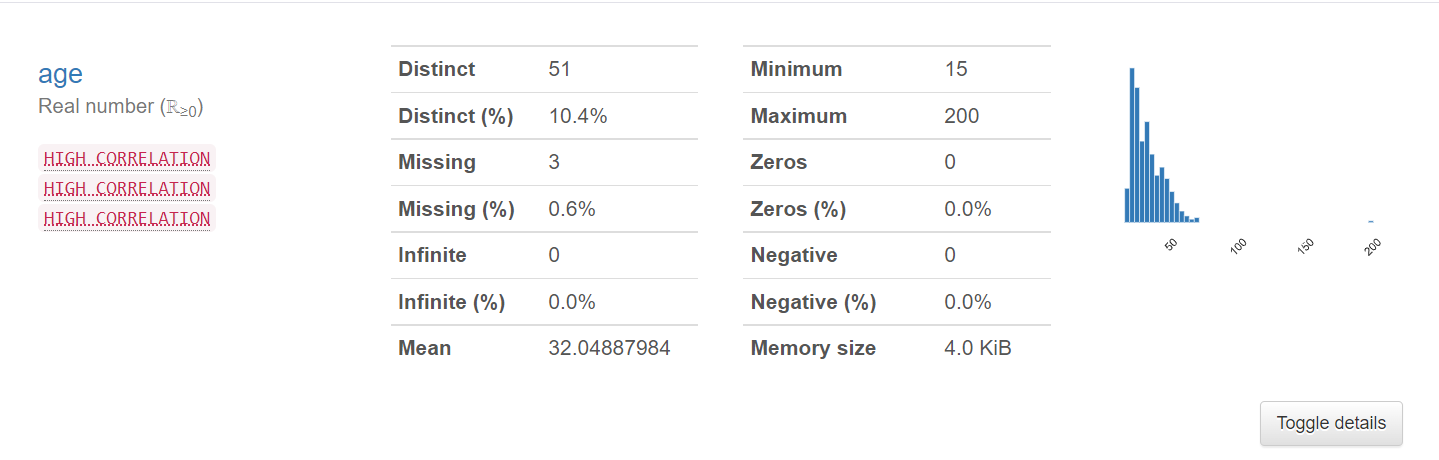


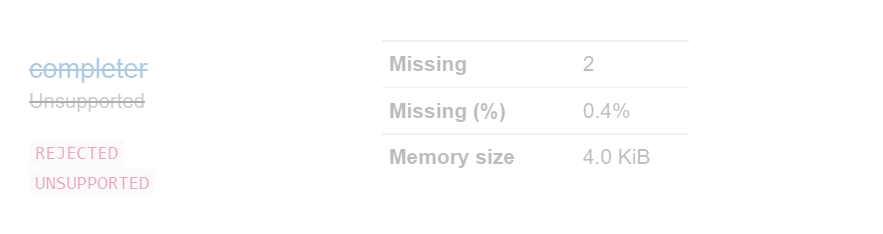


In [ ]:
#ProfileReport(df)

se remplaza los datos vacios por la meadia de la edad en este caso la media es 34 años, se selecciona 77 años ya que es la esperanza de vida promedio en ecuador

In [ ]:
df[df['age']>100]

,GoalSetting,StrategicPlanning,SelfEvaluation,TaskStrategies,Elaboration,HelpSeeking,SRL,only lecture,Atry to lecture,explore,...,isfemale,emp_student,emp_job,completer,days_act,num_events,num_ses,grade,cluster,Gano
262,2.75,3.0,3.0,2.166667,3.666667,2.5,2.847222,10,90,0,...,0,1,0,True,9,284,13,100.0,2,SI


In [ ]:
df[df['Gano']=='SI']['age'].mean()

34.660583941605836

In [ ]:
df2=df[['age','Gano']]

df2

,age,Gano
0,33.0,NO
1,19.0,NO
2,44.0,NO
3,20.0,NO
4,34.0,NO
...,...,...
489,36.0,SI
490,31.0,SI
491,40.0,SI
492,20.0,SI


In [ ]:
df2['age']=df2[df2['Gano']=='SI']['age'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['age'] = df['age'].where(df['age'] <= 77, other=df2['age'].mean())

se remplaza los datos nullos  con el  valor de la siguiente fila. ya que es un tipo string

In [ ]:
df['completer']=df['completer'].fillna(method = 'bfill') 

Limitamos la edad para que sea mayor o igual a 1

In [ ]:
df['age']= df['age'].clip(lower=1)

Se identifica que la columna completer tiene un datos atipico en este caso es la plabra 'VERDAD', como se muestra en la siguiente grafica

In [ ]:
estilo.histogram(df, x='completer',title='Histograma variable completer')

la palabra "VERDAD" se remplazara por la palabra "true"

In [ ]:
df['completer']=df['completer'].replace('VERDAD', 1)
df['completer']=df['completer'].replace(False, 0)
df['completer']=df['completer'].replace(True,1)

In [ ]:
estilo.histogram(df, x='completer',title='Histograma variable completer')

In [ ]:
estilo.histogram(df,x='age',title='Histograma variable age',text_auto=False)

In [ ]:
# Exportar el archivo limpio
df.to_excel(''.join([parent, archivo_limpio]))

## Punto 2 
Cargue en Python el dataset. Analice las variables  Atry to Lecture, TaskStrategies  y completer. Obtenga por cada una valores mínimos y máximo, medidas de tendencia central, entre otras. Concluya al respecto.

Se crea un nuevo data frame con el nombre de df_2 donde contiene las tres columnas solicitadas, las cuales tienen tipo de datos diferentes y se ejecuta el metodo describe() el cual nos muestra el los min,media,cantidad de datos,numero maximo de datos entre otra informacion relevante.

In [ ]:
df_2=df[['Atry to lecture','TaskStrategies','completer']]
df_2.describe()

,Atry to lecture,TaskStrategies,completer
count,494.000000,494.000000,494.000000
mean,64.091093,2.714238,0.321862
std,60.040738,0.751107,0.467664
min,0.000000,0.666667,0.000000
25%,0.000000,2.166667,0.000000
50%,85.000000,2.666667,0.000000
75%,120.000000,3.333333,1.000000
max,190.000000,4.000000,1.000000


In [ ]:
df_2.dtypes

Atry to lecture      int64
TaskStrategies     float64
completer            int64
dtype: object

Se muestra la moda para cada columna

In [ ]:
df_2.mode()

,Atry to lecture,TaskStrategies,completer
0,0,4.0,0


In [ ]:
df_2.isnull().any()

Atry to lecture    False
TaskStrategies     False
completer          False
dtype: bool

In [ ]:
df_3=df[['Atry to lecture','completer']]
df_4=df[['TaskStrategies','completer']]

estilo.box(df_3,x='completer',y='Atry to lecture',title='Boxplot variable completer vs Atry to lecture',notched=False)

In [ ]:
estilo.box(df_4,x='completer',y='TaskStrategies',title='Boxplot variable completer vs TaskStrategies')

# CONLUSIONES:
en el grafico "Boxplot variable completer vs TaskStrategies" se puede concluir que de 334 estudiantes que no completaron la evaluacion el  75%  tuvieron un valor de TaskStrategies de  2.83 o menos y tambien se puede concluir que de 158 estudiantes que completaron la evaluacion el 25%  tuvieron un valor de 2.79 o menos 

en el grafico "Boxplot variable completer vs Atry to lecture"  se puede observar que de 334 estudiantes que no completaron la evaluacion el 25% realizaron 0 secuencia antes entre intentar hacer la evaluacion y luego ver el video en el mooc y que de 158 estudiantes que completaron la evaluacionel 25%  realizaron 90 secuencias o menos entre intentar hacer la evaluacion y luego ver el video en el mooc.

3. Gráfico de barras y bigotes para taskStrategies y atry to lecture

In [ ]:
fig = estilo.box(df, x='Gano', y='TaskStrategies')
fig.show()

Se puede apreciar que el 50% de las personas que no ganaron, tuvieron un puntaje de 2.17 o menos en las respuestas autoreportadas por el estudiante relacionadas con TaskStrategies, en cambio, el 50% de las personas que ganaron tuvieron un puntaje de 3.17 o menos.

In [ ]:
fig = estilo.box(df, x='Gano', y='Atry to lecture')
fig.show()

Se observa que aquellas personas que intentaron una evaluación y luego vieron un video en el MOOC menos de 50 veces no ganaron. Se evidencias algunos datos atípicos, personas que realizaron esto mas de 50 veces y aún así no ganaron.

5. Gráficos


# Descripción general del dataset
## Correlación
El siguiente gráfico muestra la correlación de Pearson entre las variables, el objetivo de la limpieza de este conjunto de datos tendrá como objetivo entrenar un modelo de clasificación, la variable a predecir será “Gano”, por lo tanto, se escogerán las 10 variables que más correlación tengan con la columna “Gano”. Se utiliza el índice de correlación de Mathews debido a la capacidad que tiene de hallar correlaciones entre variables categóricas, ordinales y numéricas.

In [ ]:
cor_matrix = df.phik_matrix()

interval columns not set, guessing: ['GoalSetting', 'StrategicPlanning', 'SelfEvaluation', 'TaskStrategies', 'Elaboration', 'HelpSeeking', 'SRL', 'only lecture', 'Atry to lecture', 'explore', 'only asessment', 'Lcomplete to Atry', 'lecture to Acomplete', 'hrs', 'prior_exp', 'crs_str', 'crs_fin', 'int_topic', 'int_assess', 'edu', 'age', 'isfemale', 'emp_student', 'emp_job', 'completer', 'days_act', 'num_events', 'num_ses', 'grade', 'cluster']


In [ ]:
cor_matrix = cor_matrix.sort_values(by='Gano')
index = cor_matrix.index
cor_matrix = cor_matrix.reindex(columns=index)

In [ ]:
fig = estilo.heatmap(cor_matrix)
fig.show()

Las variables escogidas son:

In [ ]:
cols_escogidas = {"GoalSetting", "StrategicPlanning", "SelfEvaluation", "TaskStrategies", "SRL", "Atry to lecture", "explore", "isfemale", "days_act", "num_events", "num_ses", "Gano","age", "completer"}
print(cols_escogidas)

{'GoalSetting', 'StrategicPlanning', 'completer', 'SRL', 'SelfEvaluation', 'num_ses', 'num_events', 'Atry to lecture', 'explore', 'age', 'isfemale', 'TaskStrategies', 'days_act', 'Gano'}


In [ ]:
df_procesado = df[cols_escogidas]
cor_matrix_procesado = df_procesado.phik_matrix()

interval columns not set, guessing: ['GoalSetting', 'StrategicPlanning', 'completer', 'SRL', 'SelfEvaluation', 'num_ses', 'num_events', 'Atry to lecture', 'explore', 'age', 'isfemale', 'TaskStrategies', 'days_act']


In [ ]:
cor_matrix_procesado = cor_matrix_procesado.sort_values(by='Gano')
index = cor_matrix_procesado.index
cor_matrix_procesado = cor_matrix_procesado.reindex(columns=index)

La matriz de correlación con las variables seleccionada es

In [ ]:
fig = estilo.heatmap(cor_matrix_procesado.sort_values(by='Gano'))
fig.show()

In [ ]:
fig = estilo.histogram(df, x='Gano')
fig.show()

In [ ]:
personas_ganaron = df.loc[df['Gano'] == 'SI']['Gano'].count()
personas_no_ganaron = df.loc[df['Gano'] == 'NO']['Gano'].count()
total = df['Gano'].count()
wprint(f'De {total} personas, el {personas_ganaron/total:.2%} ganaron, comparado con el {personas_no_ganaron/total:.2%} que no ganaron, se observa un buen balanceo de clases, aunque hubo mas personas que ganaron, la diferencia no es mucha.')

    De 494 personas, el 55.47% ganaron, comparado con el 44.53% que no ganaron, se observa un buen
    balanceo de clases, aunque hubo mas personas que ganaron, la diferencia no es mucha.


In [ ]:
fig = estilo.histogram(df, x='isfemale')
fig.show()

In [ ]:
mujeres = df.loc[df['isfemale'] == 1]['isfemale'].count()
hombres = df.loc[df['isfemale'] == 0]['isfemale'].count()
total = mujeres + hombres
wprint(f'De {total} personas, el {mujeres/total:.2%} son mujeres, comparado con el {hombres/total:.2%} que son hombres, se observa una gran diferencia entre hombres y mujeres que practicaron la prueba.')

    De 494 personas, el 9.92% son mujeres, comparado con el 90.08% que son hombres, se observa una
    gran diferencia entre hombres y mujeres que practicaron la prueba.


In [ ]:
fig = estilo.box(df,y='age')
fig.show()

El 50% de las personas tienen 29 años o menos, mientras que el 75% tienen 39 o menos. De acuerdo con la varianza y tendencia central de los datos, se consideran datos atípicos aquellas personas que tengan más de 63 años. Existe un registro de 200 años el cuál se dejará como nulo.

In [ ]:
fig = estilo.box(df, x='Gano', y='num_events')
fig.show()

Se observa una clara influencia en 

In [ ]:
fig = estilo.box(df, y='days_act')
fig.show()

Se observa que que los estudiantes 


In [ ]:
fig = estilo.box(df, x='Gano', y='StrategicPlanning')
fig.show()

In [ ]:
cross_tab=pd.crosstab(df['Gano'],df_procesado['isfemale'])
# Porcentaje
cross_tab = cross_tab/cross_tab.sum()
fig = estilo.heatmap(cross_tab,text_auto='.2%', zmin=0, zmax=1)
fig.show()

Se observa que la probabilidad de ganar no depende del género de la persona, esto se observa al ver que las probabilidades para cada género es muy cercana al 50%.

In [ ]:
cross_tab=pd.crosstab(df['Gano'],df['prior_exp'])
# Porcentaje
cross_tab = cross_tab/cross_tab.sum()
fig = estilo.heatmap(cross_tab,text_auto='.2%', zmin=0, zmax=1)
fig.show()

El 63.73% de las personas que tenían experiencia previa ganaron el examen vs el 44.29% que no, esto indica que tener experiencia previa influye en el resultado del curso.

In [ ]:
fig = estilo.scatter(df, x='SRL',  y='days_act', color='Gano', correct_incorrect_map={'correcto':'SI','incorrecto':'NO'})
fig.show()

Se observa que aquellas personas que estuvieron activos en el curso menos de 10 días y obtuvieron en promedio una calificación autoreportada por el estudiante en GoalSetting, StrategicPlanning, SelfEvaluation, TaskStrategies y Elaboration menor a 2.5 tenían más probabilidad de no ganar que el resto.

In [ ]:
fig = estilo.scatter(df, x='SRL',  y='num_events', color='Gano', correct_incorrect_map={'correcto':'SI','incorrecto':'NO'})
fig.show()

Se observa que aquellas personas que asistieron a menos de 71 eventos y obtuvieron en promedio una calificación autoreportada por el estudiante en GoalSetting, StrategicPlanning, SelfEvaluation, TaskStrategies y Elaboration menor a 2.5 tenían más probabilidad de no ganar que el resto.

A continuación se analizará la información por rangos de edad.

In [ ]:
fig = estilo.pyramid(df, x='age', bins=9, cat_col='isfemale',cat1=0,cat1name='Hombres',
              cat1color=estilo.colores['masculino'],cat2=1,cat2name='Mujeres',
              cat2color=estilo.colores['femenino'])
fig.show()

Se puede ver que el grupo está compuesto por personas jóvenes, el grupo más grande son los hombres entre 22 y 28 años, se observa adicionalmente una asimetría hacia la derecha para ambos grupos de personas.

La disparidad de género se conserva en todos los rangos de edad.

In [ ]:
fig = estilo.pyramid(df, x='age', bins=9, cat_col='Gano',cat1='SI',cat1name='Ganó',
              cat1color=estilo.colores['correcto'],cat2='NO',cat2name='No ganó',
              cat2color=estilo.colores['incorrecto'])
fig.show()

Se observa que a medida que la edad aumenta, la proporción entre personas que ganaron el curso aumentan sobre las que lo perdieron, las personas demasiado jóvenes (Entre 15 y 22 años), tuvieron una tasa de éxito menor (39.65%) que las personas de mayor edad (Entre 35 y 42) (65,15%). A continuación se muestra la tasa de éxito por edad:


| Rango edad | Perdieron | Ganaron | Total personas | Tasa de éxito |
|:----------:|:---------:|:-------:|:--------------:|:-------------:|
|    15-22   |     70    |    46   |       116      |     %39,66    |
|    22-28   |     58    |    64   |       122      |     %52,46    |
|    28-35   |     46    |    53   |       99       |     %53,54    |
|    35-42   |     23    |    43   |       66       |     %65,15    |
|    42-48   |     14    |    30   |       44       |     %68,18    |
|    48-55   |     7     |    24   |       31       |     %77,42    |
|    55-61   |     0     |    9    |        9       |      %100     |
|    61-68   |     2     |    5    |        7       |     %71,43    |

## Punto 6
Primero se seleccionarán las primeras 8 variables cuya correlación sea mayor al 70% con respecto a la variable Gano. Se omitirán las variables cluster y grade pues a partir de estas se calcula Gano.

In [ ]:
cor_matrix = df.phik_matrix()
cor_matrix[['Gano']].sort_values(by='Gano',ascending=False)

interval columns not set, guessing: ['GoalSetting', 'StrategicPlanning', 'SelfEvaluation', 'TaskStrategies', 'Elaboration', 'HelpSeeking', 'SRL', 'only lecture', 'Atry to lecture', 'explore', 'only asessment', 'Lcomplete to Atry', 'lecture to Acomplete', 'hrs', 'prior_exp', 'crs_str', 'crs_fin', 'int_topic', 'int_assess', 'edu', 'age', 'isfemale', 'emp_student', 'emp_job', 'completer', 'days_act', 'num_events', 'num_ses', 'grade', 'cluster']


,Gano
Gano,1.000000
cluster,1.000000
grade,1.000000
SRL,0.969236
num_events,0.965963
Atry to lecture,0.958001
days_act,0.928648
num_ses,0.928644
TaskStrategies,0.865994
StrategicPlanning,0.859345


In [ ]:
# Función para hallar el valor que optimiza el f1-score para modelos sencillos de un solo atributo
def optim_f1(variable):
  def predict(threshold, variable):
    return np.where(df[variable] < threshold, 'NO', 'SI')
  lista = np.linspace(df[variable].min(),df[variable].max(),1000)
  max_f1 = 0
  max_thres = 0
  cantidad = df['Gano'].count()
  for x in lista:
    pred = predict(x, variable) == df['Gano']
    TP = sum(pred.loc[df['Gano']=='SI']) #True Positives
    TN = sum(pred.loc[df['Gano']=='NO']) # True Negatives
    FP = pred.loc[df['Gano']=='SI'].count() - TP # False Positives
    FN = pred.loc[df['Gano']=='NO'].count() - TN # False negatives
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*precision*recall/(precision+recall)
    if f1 > max_f1:
      max_f1 = f1
      max_thres = x
  print(f'{variable}: Valor que optimiza f1-score: {max_thres:.2f}. Con este valor se obtiene un f1-score de:{max_f1:.2%}')
  return max_thres, max_f1

In [ ]:
max_thres, max_f1 = optim_f1('SRL')
max_thres, max_f1 = optim_f1('num_events')
max_thres, max_f1 = optim_f1('Atry to lecture')
max_thres, max_f1 = optim_f1('days_act')
max_thres, max_f1 = optim_f1('num_ses')
max_thres, max_f1 = optim_f1('TaskStrategies')
max_thres, max_f1 = optim_f1('StrategicPlanning')

SRL: Valor que optimiza f1-score: 2.42. Con este valor se obtiene un f1-score de:94.82%
num_events: Valor que optimiza f1-score: 71.56. Con este valor se obtiene un f1-score de:100.00%
Atry to lecture: Valor que optimiza f1-score: 9.13. Con este valor se obtiene un f1-score de:99.64%
days_act: Valor que optimiza f1-score: 5.04. Con este valor se obtiene un f1-score de:89.08%
num_ses: Valor que optimiza f1-score: 11.09. Con este valor se obtiene un f1-score de:89.75%
TaskStrategies: Valor que optimiza f1-score: 2.34. Con este valor se obtiene un f1-score de:84.87%
StrategicPlanning: Valor que optimiza f1-score: 2.50. Con este valor se obtiene un f1-score de:84.47%


In [ ]:
cross_tab=pd.crosstab(df['Gano'],df['completer'])
fig = estilo.heatmap(cross_tab,text_auto=True)
fig.show()

In [ ]:
# Porcentaje
cross_tab = round(cross_tab/cross_tab.sum()*100, 2)
print('Procentaje por completer')
cross_tab

Procentaje por completer


completer,0,1
Gano,,
NO,65.67,0.0
SI,34.33,100.0


Las variables seleccionada son: 'SRL', 'num_events', 'Atry to lecture', 'days_act', 'num_ses', 'TaskStrategies', 'StrategicPlanning', 'completer'.

Para que más estudiantes ganen el curso, se recomiendan los siguientes cambios:

1. SRL: Una de las variables que se encontró que impacta más en el resultado del exámen es la autopercepción de los estudiantes, por lo tanto, identificar de manera temprana aquellos estudiantes cuya autoevaluación (Promedio entre GoalSetting, StrategicPlanning, SelfEvaluation, TaskStrategies, Elaboration y  HelpSeeking) tiene un puntaje inferior a 2.42 puede ayudar a desarrollar estrategias de apoyo para estos estudiantes.

2. num_events: Es importante revisar la asistencia a los eventos, aquellos estudiantes que asisiteron a menos de 71 eventos tienen más riesgo de perder el curso.

3. Atry to lecture: Se recomienda incentivar a los estudiantes a que vean los videos en el MOOC después de intentar una evaluación, se encontró que la mayoría de estudiantes que realizaron esto más de 9 veces, ganaron el curso.

4. days_act: Muy relacionado con la asistencia, es importante llevar un seguimiento de los estudiantes que faltan mas, se encontró que aquellos que estuvieron menos de 5 días activos tienen un mayor riesgo de perder el curso.

5. num_ses: El número de sesiones que realiza el estudiante durante la cursada del MOC también tiene una alta correlación con perder o ganar el curso, se encontró que un modelo que predice los estudiantes que pierden si asistieron a menos de 11 sesiones tuvo un F1 score de 89%, acertando en el 88% y fallando en el 12%.

6. TaskStrategies: De los ítems incluidos en la evaluación, TaskStrategies es el ítem que más influye en el resultado del curso, se encontró que un modelo que predice el resultado del curso basado en si el resultado de TaskStrategies es superior a 2.34, tiene un f1score de 84.87 %.

7. StrategicPlanning: es otro ítem que influye en el resultado del curso, un modelo que predice el resultado del curso para aquellos estudiantes que sacaron mas de 2.54 tiene un f1score de 84%

8. Completer: el 100% de los estudiantes que completaron el curso, lo ganaron, solo el 34.33% de los estudiantes que no completaron el curso, lo ganaron.